In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

In [19]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def get_index(prefix):
    client_sdf = spark.read.csv(f"{prefix}/*/client/0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    server_sdf = spark.read.csv(f"{prefix}/*/server/0-0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    return server_sdf.join(client_sdf, on='prefix')\
        .withColumn("duration", col("duration").cast(T.IntegerType()))\
        .withColumn("txns", col("txns").cast(T.IntegerType()))\
        .withColumn("clients", col("clients").cast(T.IntegerType()))\
        .withColumn("rate", col("rate").cast(T.IntegerType()))

In [34]:
PREFIX = "main/ycsb-asym"

index_sdf = get_index(PREFIX).withColumn("asym_ratio", F.regexp_extract("prefix", r"asym_ratio(\d+)", 1)).cache()
index_df = index_sdf\
    .withColumn("config_name", F.regexp_replace("config_name", "\.conf", ""))\
    .toPandas()\
    .convert_dtypes()\
    .astype({
        "wl:hot": "int32",
        "wl:mh": "int32",
        "wl:mp": "int32",
    })

index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,asym_ratio
0,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients3000asym_ratio50,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,50
1,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients3000asym_ratio60,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,60
2,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients3000asym_ratio70,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,70
3,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients3000asym_ratio80,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,80
4,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients3000asym_ratio90,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,90
5,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients200asym_ratio50,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,50
6,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients200asym_ratio60,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,60
7,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients200asym_ratio70,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,70
8,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients200asym_ratio80,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,80
9,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients200asym_ratio90,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,90


# Throughput

In [26]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=5,
        duration_sec=50
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_sdf):
    # Extract all prefixes in the index
    throughput_df = index_sdf.select("prefix").toPandas()
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")


throughput_df = from_cache_or_compute(
    f'{PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(index_sdf.where(col("clients") == 3000)).sort_values("asym_ratio"),
    ignore_cache=IGNORE_CACHE,
)

file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients3000asym_ratio50 47815.7699949181
file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients3000asym_ratio60 47531.653066658626
file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients3000asym_ratio70 48528.517012901364
file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients3000asym_ratio80 48110.99854442916
file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients3000asym_ratio90 47432.96986482962
Saved to: main/ycsb-asym/throughput.parquet


# Latency

In [35]:
prefixes = list(
    map(
        lambda r : r["prefix"],
        index_sdf.select("prefix").where(col("clients") == 200).collect()
    )
)
latency_sdf = latency(spark, prefixes).cache()

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("p50"),
    F.percentile_approx("latency", 0.90).alias("p90"),
    F.percentile_approx("latency", 0.95).alias("p95"),
    F.percentile_approx("latency", 0.99).alias("p99"),
]

latency_sdf = latency_sdf.groupBy("prefix").agg(*percentile_cols).cache()

In [36]:
IGNORE_CACHE = False

latency_df = from_cache_or_compute(
    f'{PREFIX}/latency.parquet',
    lambda: latency_sdf.toPandas().merge(index_df, on="prefix").sort_values("asym_ratio"),
    ignore_cache=IGNORE_CACHE,
)
latency_df

Saved to: main/ycsb-asym/latency.parquet


,prefix,p50,p90,p95,p99,version,config_name,duration,txns,clients,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,asym_ratio
2,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients200asym_ratio50,87.998208,124.995072,140.085248,220.053504,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,50
1,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients200asym_ratio60,95.744512,140.546816,157.972224,224.577536,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,60
3,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients200asym_ratio70,105.878528,156.081408,175.148288,246.063360,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,70
4,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients200asym_ratio80,120.099072,176.145664,197.913856,266.996224,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,80
0,file:///home/ctring/data/detock/main/ycsb-asym/ddr_ts-clients200asym_ratio90,127.725056,188.514816,212.547584,294.964224,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,90


# Plot

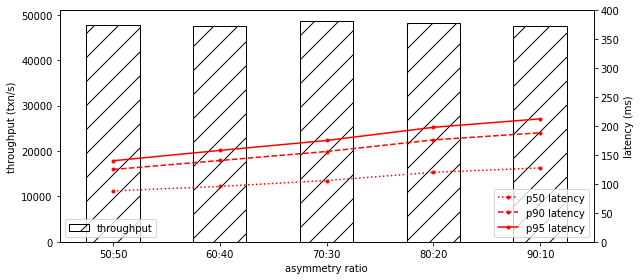

In [37]:
_, ax = plt.subplots(1, 1, figsize=(9, 4))

throughput_df.plot.bar(ax=ax, x="asym_ratio", y="throughput", rot=0, fill=False, hatch='/')
ax.set_ylabel("throughput (txn/s)")
ax.set_xlabel("asymmetry ratio")
ax.legend(loc="lower left")
ax2 = ax.twinx()

latency_df.plot(ax=ax2, x="asym_ratio", y="p50", label='p50 latency', linestyle='dotted', marker='.', color="red")
latency_df.plot(ax=ax2, x="asym_ratio", y="p90", label='p90 latency', linestyle='dashed', marker='.', color="red")
latency_df.plot(ax=ax2, x="asym_ratio", y="p95", label='p95 latency', marker='.', color="red")
# latency_df.plot(ax=ax2, x="asym_ratio", y="p99", label='p99 latency', marker='.', color="red")
ax2.set_ylabel("latency (ms)")
ax2.set_ylim((0, 400))
ax2.set_xticklabels(["50:50", "60:40", "70:30", "80:20", "90:10"])

ax2.legend(loc="lower right")
 
plt.tight_layout()
plt.savefig("output/asymmetry.pdf")
